In [1]:
import mdtraj as md
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# load alanine dipeptide trajectory
molecule = md.load_pdb("../simulation/single.pdb")


In [3]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms]
water = Atoms(positions=molecule.xyz[0], numbers=atomic_nums)
show_ase(water)


NGLWidget()

In [4]:
# Relative position of atoms on one molecule
poitions = molecule.xyz[0]
com = poitions.mean(axis=0)

relative_pos = poitions-com

# atomic Number
atomic_nums = np.array(
    [[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# Vander wall Radii
vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# Atomic Mass
mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T


print("Relative positions:\n", relative_pos)
print("\natomic_numbers:\n", atomic_nums)
print("\nVander wall Radii:\n", vdwr)
print("\nAtomic Mass:\n", mass)


Relative positions:
 [[-0.01795 -0.03465 -0.008  ]
 [ 0.07775 -0.03465 -0.008  ]
 [-0.04185  0.05795 -0.008  ]
 [-0.01795  0.01135  0.024  ]]

atomic_numbers:
 [[8]
 [1]
 [1]
 [0]]

Vander wall Radii:
 [[0.152]
 [0.12 ]
 [0.12 ]
 [0.   ]]

Atomic Mass:
 [[15.99943 ]
 [ 1.007947]
 [ 1.007947]
 [ 0.      ]]


In [5]:
node_features = np.concatenate((relative_pos, atomic_nums, vdwr, mass), axis=1)
print("Node Features:\n", node_features)
print("\nNode Features Shape:\n", node_features.shape)

Node Features:
 [[-1.79500002e-02 -3.46500017e-02 -8.00000038e-03  8.00000000e+00
   1.52000000e-01  1.59994300e+01]
 [ 7.77500048e-02 -3.46500017e-02 -8.00000038e-03  1.00000000e+00
   1.20000000e-01  1.00794700e+00]
 [-4.18500006e-02  5.79500012e-02 -8.00000038e-03  1.00000000e+00
   1.20000000e-01  1.00794700e+00]
 [-1.79500002e-02  1.13499984e-02  2.40000002e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

Node Features Shape:
 (4, 6)


In [6]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list, to_list])


In [7]:
graph = data.Data(x=torch.from_numpy(node_features),
                  edge_index=torch.from_numpy(edge_list))


In [8]:
print(graph)
print(graph.edge_index)

Data(x=[4, 6], edge_index=[2, 4])
tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])


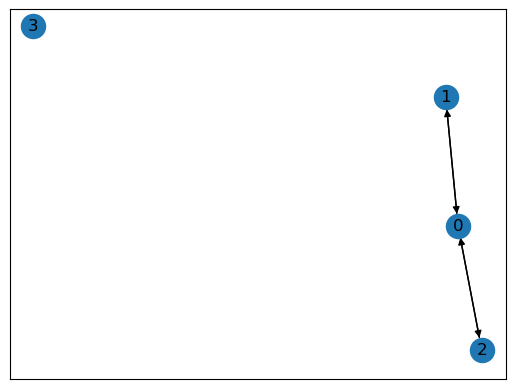

In [9]:
vis = to_networkx(graph)
nx.draw_networkx(vis)

In [10]:
graphs = [graph for _ in range(50)]


In [11]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index.long()

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [12]:
def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g


def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, int(k*num_nodes)))
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    return g, new_h, idx

class Pool(torch.nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = torch.nn.Sigmoid()
        self.proj = torch.nn.Linear(in_dim, 1)
        self.drop = torch.nn.Dropout(p=p) if p > 0 else torch.nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(torch.nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, h, edge_indices,factor=1):
        # add zeros to h factor times
        h = torch.cat([h, torch.zeros(h.shape[0]*factor, h.shape[1]).to(h.device)], dim=0)
        return h

In [13]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

class VariationalGCNEncoder(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 4 * out_channels)
        self.conv2 = GCNConv(4 * out_channels, 2 * out_channels)

        # add SAG pooling layer
        self.pool = SAGPooling(in_channels, 0.5)

        # Using a self defined pooling layer
        # self.pool = Pool(0.5,in_channels, 0.5)

        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        
        x, edge_index,_,_,_,_ = self.pool(x, edge_index)

        # adj_g = convert_to_adj(edge_index, x.shape[0])
        # adj_g, x, idx = self.pool(adj_g, x)
        # edge_index = convert_to_edge_index(adj_g)
        
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        
        return mu, logstd, edge_index


In [14]:
import torch
import torch.nn.functional as F

class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels,sigmoid=True):
        super().__init__()
        self.unpool = Unpool()
        self.conv_pre1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_pre2 = GCNConv(2 * out_channels, out_channels)
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        
    def forward(self, z, edge_index,sigmoid=True):
        z = self.unpool(z, edge_index,factor=1)
        edge_index = torch.cat([edge_index, torch.zeros(2,max(0,z.shape[0]-edge_index.shape[1]) ).long()], dim=1)
        z = self.conv1(z, edge_index).relu()
        z = self.conv2(z, edge_index).relu()

        return z, edge_index
        

In [15]:
in_channels = graph.num_features
out_channels = 3
lr = 1e-2
n_epochs = 20
batch_size = 1

model = VGAE(VariationalGCNEncoder(in_channels, out_channels),
             VariationalGCNDecoder(out_channels, in_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [16]:
print(model)

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(6, 12)
    (conv2): GCNConv(12, 6)
    (pool): SAGPooling(GraphConv, 6, ratio=0.5, multiplier=1.0)
    (conv_mu): GCNConv(6, 3)
    (conv_logstd): GCNConv(6, 3)
  )
  (decoder): VariationalGCNDecoder(
    (unpool): Unpool()
    (conv_pre1): GCNConv(3, 12)
    (conv_pre2): GCNConv(12, 6)
    (conv1): GCNConv(3, 12)
    (conv2): GCNConv(12, 6)
  )
)


In [17]:
train_loader = DataLoader(graphs, batch_size=batch_size)


In [18]:
def train():
    model.train()
    model.double()
    loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z, encoded_edge = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge = model.decode(z, encoded_edge)
        # print("x", data.x.shape)
        # print("edge", data.edge_index.shape)
        # print("decoded x", decoded_x.shape)
        # print("decoded edge", decoded_edge.shape)
        lossF = F.mse_loss(decoded_x, data.x)
        lossE = F.mse_loss(data.edge_index, decoded_edge.float())
        loss = lossF + lossE
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)


In [19]:
Losses = []
for epoch in range(1, n_epochs + 1):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    Losses.append(loss)
    
    

Epoch: 001, Loss: 11.8011
Epoch: 002, Loss: 8.2682
Epoch: 003, Loss: 7.8944
Epoch: 004, Loss: 7.6219
Epoch: 005, Loss: 7.5771
Epoch: 006, Loss: 7.6891
Epoch: 007, Loss: 7.5559
Epoch: 008, Loss: 7.3985
Epoch: 009, Loss: 7.4584
Epoch: 010, Loss: 7.4831
Epoch: 011, Loss: 7.3149
Epoch: 012, Loss: 7.3650
Epoch: 013, Loss: 7.3210
Epoch: 014, Loss: 7.2792
Epoch: 015, Loss: 7.3420
Epoch: 016, Loss: 7.2374
Epoch: 017, Loss: 7.2922
Epoch: 018, Loss: 7.2111
Epoch: 019, Loss: 7.2409
Epoch: 020, Loss: 7.3000


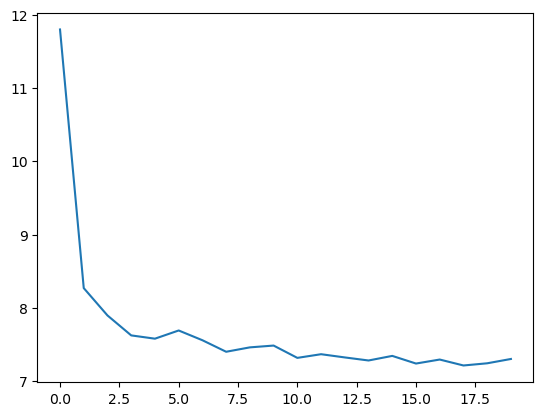

In [20]:
plt.plot(Losses)


In [21]:
model.double()
z,encoded_edge_index = model.encode(graph.x, graph.edge_index)
r,decoded_edge_index = model.decode(z, encoded_edge_index)
decoded_edge_index = graph.edge_index
print("Input Graph features: \n", graph.x)
print("\nInput Edge Index: \n", graph.edge_index)
print("\nEncoded Graph: \n", z)
print("\nDecoded Node features: \n", r)
print("\nDecoded Edge Index: \n", decoded_edge_index)

Input Graph features: 
 tensor([[-1.7950e-02, -3.4650e-02, -8.0000e-03,  8.0000e+00,  1.5200e-01,
          1.5999e+01],
        [ 7.7750e-02, -3.4650e-02, -8.0000e-03,  1.0000e+00,  1.2000e-01,
          1.0079e+00],
        [-4.1850e-02,  5.7950e-02, -8.0000e-03,  1.0000e+00,  1.2000e-01,
          1.0079e+00],
        [-1.7950e-02,  1.1350e-02,  2.4000e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00]], dtype=torch.float64)

Input Edge Index: 
 tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])

Encoded Graph: 
 tensor([[ 0.7908, -1.6378, -0.9405],
        [-1.2599, -0.8957, -0.5163]], dtype=torch.float64,
       grad_fn=<AddBackward0>)

Decoded Node features: 
 tensor([[0.0000, 0.0000, 0.0000, 3.0781, 0.0000, 5.7380],
        [0.0000, 0.0000, 0.0000, 3.0781, 0.0000, 5.7380],
        [0.0000, 0.0000, 0.0000, 0.5709, 0.0000, 0.6414],
        [0.0000, 0.0000, 0.0000, 0.5709, 0.0000, 0.6414]], dtype=torch.float64,
       grad_fn=<ReluBackward0>)

Decoded Edge Index: 
 tensor([[0, 1, 0, 2]

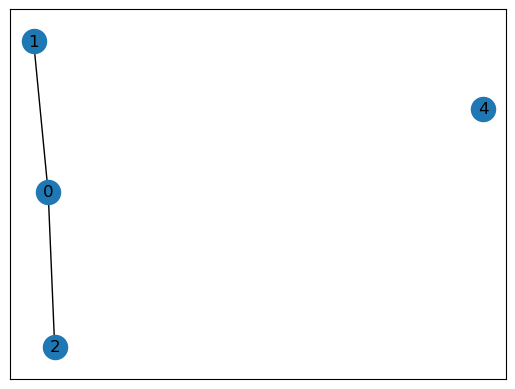

In [22]:
add_self_loops = False
adj_binary = convert_to_adj(decoded_edge_index, r.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(
        indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw_networkx(G, with_labels=True)
plt.show()
